<a href="https://colab.research.google.com/github/chase-urasaki/ADCS-Visualizations/blob/main/Attitude_Dynamics_Software_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
import mpl_toolkits.mplot3d.axes3d as p3
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import HTML

# Define spacecraft mass, inertia, external torque and inital state

Mass and Inertia are for a 1U cubesat - feel free to change, but these values won't be wrapped in the function. You may use the sliders OR run the functions with values inputed for arguements.

In [ ]:
m = 1.33 # kg
l = 0.1 # m
I_xx = 1/12*m*(2*l**2) # kg m^2
I_yy = 1/12*m*(2*l**2) # kg m^2
I_zz = 1/12*m*(2*l**2) # kg m^2

In [ ]:
def run_dynamics_with_no_ext_torque_for(phi, theta, psi, omega_phi, omega_theta, omega_psi):
  """ input phi, theta, psi, omega_phi (roll velocity), omega_theta (pitch velocity), omega_psi (yaw velocity) in degrees"""
  #define inertia

  I = np.array([[I_xx, 0, 0],[0, I_yy, 0],[0, 0 ,I_zz]])

  # define external torque
  tau = np.array([[0],[0], [0]])

  # define initial state
  # euler angles
  phi = phi * np.pi /180     
  theta = theta * np.pi/180       
  psi = psi * np.pi/180      
  # rotation matrix 
  A_x = np.array([[1, 0, 0],
                [0, np.cos(phi), -np.sin(phi)], 
                [0, np.sin(phi), np.cos(phi)]])
  A_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                [0, 1, 0], 
                [-np.sin(theta), 0, np.cos(theta)]])
  A_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                [np.sin(psi), np.cos(psi), 0], 
                [0, 0, 1]])
  A = A_z @ A_y @ A_x
  # euler axis angle
  theta_a = np.arccos((A[0,0]+A[1,1]+A[2,2]-1)/2)
  e_1 = (A[2,1]-A[1,2])/(2*np.sin(theta_a))
  e_2 = (A[0,2]-A[2,0])/(2*np.sin(theta_a))
  e_3 = (A[1,0]-A[0,1])/(2*np.sin(theta_a))
  # quaternion
  q_x0 = e_1*np.sin(theta_a/2)
  q_y0 = e_2*np.sin(theta_a/2)
  q_z0 = e_3*np.sin(theta_a/2)
  q_w0 = np.cos(theta_a/2)
  q_0 = np.array([q_x0, q_y0, q_z0, q_w0])

  omega_x0 = omega_phi* np.pi/180 
  omega_y0 = omega_theta * np.pi/180
  omega_z0 = omega_psi * np.pi/180
  omega_0 = np.array([omega_x0,omega_y0,omega_z0])

  # initiate state with rotation matrix
  r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
  s_0 = np.concatenate((r_0,omega_0), axis=0)

  # time points
  t = np.linspace(0, 100, 1001)

  # integrate
  y = odeint(R_model, s_0, t, args=(I,tau))
  R_t = y[:,0:9]
  w_t = y[:,9::]

  return t, R_t, w_t

In [ ]:
def R_model(s,t,I,tau):
    # break out state
    r = s[0:9]
    R = np.array([r[0:3],r[3:6],r[6:9]])
    w1 = s[9]
    w2 = s[10]
    w3 = s[11]
    w = np.array([[w1],[w2],[w3]])
    
    # define derivative
    wcross = np.array([[0,w3,-w2],[-w3,0,w1],[w2,-w1,0]])
    
    Rdot = R@wcross
    rdot = np.concatenate((Rdot[0,:], Rdot[1,:], Rdot[2,:]))
    
    wdot = -np.linalg.inv(I)@(wcross@I@w-tau)
    
    # return state derivative
    sdot = np.concatenate((rdot,wdot[:,0]), axis=0)
    
    return sdot

In [ ]:
def plot_dynamics_with_no_ext_torque(phi, theta, psi, omega_phi, omega_theta, omega_psi):
  t, R_t, w_t = run_dynamics_with_no_ext_torque_for(phi, theta, psi, omega_phi, omega_theta, omega_psi)
  fig = plt.figure(figsize=(20,20))
  fig.tight_layout(pad = 5)
  plt.subplot(3,4,1)
  plt.plot(t,R_t[:,0])
  plt.ylabel(r'R$_{11}$')
  plt.ylim(-1.1,1.1)
  plt.subplot(342)
  plt.plot(t,R_t[:,1])
  plt.ylabel(r'R$_{12}$')
  plt.ylim(-1.1,1.1)
  plt.subplot(343)
  plt.plot(t,R_t[:,2])
  plt.ylabel(r'R$_{13}$')
  plt.ylim(-1.1,1.1)
  plt.subplot(344)
  plt.plot(t,w_t[:,0])
  plt.ylabel(r'w$_1$')
  plt.subplot(345)
  plt.plot(t,R_t[:,3])
  plt.ylabel(r'R$_{21}$')
  plt.ylim(-1.1,1.1)
  plt.subplot(346)
  plt.plot(t,R_t[:,4])
  plt.ylabel(r'R$_{22}$')
  plt.ylim(-1.1,1.1)
  plt.subplot(347)
  plt.plot(t,R_t[:,5])
  plt.ylabel(r'R$_{23}$')
  plt.subplot(348)
  plt.plot(t,w_t[:,1])
  plt.ylabel(r'w$_2$')
  plt.subplot(349)
  plt.plot(t,R_t[:,6])
  plt.ylabel(r'R$_{31}$')
  plt.ylim(-1.1,1.1)
  plt.subplot(3,4,10)
  plt.plot(t,R_t[:,7])
  plt.ylabel(r'R$_{32}$')
  plt.ylim(-1.1,1.1)
  plt.subplot(3,4,11)
  plt.plot(t,R_t[:,8])
  plt.ylabel(r'R$_{33}$')
  plt.subplot(3,4,12)
  plt.plot(t,w_t[:,2])
  plt.ylabel(r'w$_3$')
  plt.show()
  plt.close()

In [ ]:
phi_slider = widgets.IntSlider(value = 0.0, min = -360, max = 360, step = 1, description=r'phi (roll)')
theta_slider = widgets.IntSlider(value = 0.0, min = -180, max = 180, step = 1, description='theta (pitch)')
psi_slider = widgets.IntSlider(value = 0.0, min = -360, max = 360, step = 1, description='psi (yaw)')
omega_phi_slider = widgets.IntSlider(value = 0.0, min = -360, max = 360, step = 1, description=r'omega phi (roll velocity)')
omega_theta_slider = widgets.IntSlider(value = 0.0, min = -180, max = 180, step = 1, description='omega theta (pitch velocity)')
omega_psi_slider = widgets.IntSlider(value = 0.0, min = -360, max = 360, step = 1, description='omega psi (yaw velocity)')

In [ ]:
widgets.interact(plot_dynamics_with_no_ext_torque, phi = phi_slider, theta = theta_slider, psi = psi_slider, omega_phi = omega_phi_slider, omega_theta = omega_theta_slider, omega_psi = omega_psi_slider)

Give the program a few moments to update all the plots before running the animator. 

In [ ]:
t, R_t, _ = run_dynamics_with_no_ext_torque_for(phi_slider.value, theta_slider.value, psi_slider.value, omega_phi_slider.value, omega_theta_slider.value, omega_psi_slider.value)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.suptitle('On-Diagonal Inertia')
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') #red
ax.text(1.5, 0, 0, r'x', color = 'k')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') #orange
ax.text(0, 1.5, 0, r'y', color = 'k')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') #blue 
ax.text(0, 0, 1.5, r'z', color = 'k')
ax.set(xlim=(-1.5, 1.5), 
          ylim=(-1.1,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t[0,0]], [0,R_t[0,3]], [0,R_t[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t[0,1]], [0,R_t[0,4]], [0,R_t[0,7]], color = 'orange', linewidth = 10)
z_b, = ax.plot([0,R_t[0,2]], [0,R_t[0,5]], [0,R_t[0,8]], color = 'blue', linewidth = 10)

# animation function. This is called sequentially
def drawframe(n): 
    x_b.set_data([0,R_t[n,0]], [0,R_t[n,1]])
    x_b.set_3d_properties([0,R_t[n,2]], 'z')
    y_b.set_data([0,R_t[n,3]], [0,R_t[n,4]])
    y_b.set_3d_properties([0,R_t[n,5]], 'z')
    z_b.set_data([0,R_t[n,6]], [0,R_t[n,7]])
    z_b.set_3d_properties([0,R_t[n,8]], 'z')
    return (x_b, y_b, z_b)

anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)

HTML(anim.to_html5_video())

# Investigate Motion using quaternion Kinematics

In [ ]:
def run_dynamics_with_no_ext_torque_in_quat_for(phi, theta, psi, omega_phi, omega_theta, omega_psi):
  """ input phi, theta, psi, omega_phi (roll velocity), omega_theta (pitch velocity), omega_psi (yaw velocity) in degrees"""
  #define moment of inertia
  I = np.array([[I_xx, 0, 0],[0, I_yy, 0],[0, 0 ,I_zz]])

  # define external torque
  tau = np.array([[0],[0], [0]])

  # define initial state
  # euler angles
  phi = phi * np.pi /180     # "roll" FEEL FREE TO CHANGE THIS VALUE
  theta = theta * np.pi/180       # "pitch" FEEL FREE TO CHANGE THIS VALUE
  psi = psi * np.pi/180      # "yaw" FEEL FREE TO CHANGE THIS VALUE
  # rotation matrix 
  A_x = np.array([[1, 0, 0],
                [0, np.cos(phi), -np.sin(phi)], 
                [0, np.sin(phi), np.cos(phi)]])
  A_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                [0, 1, 0], 
                [-np.sin(theta), 0, np.cos(theta)]])
  A_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                [np.sin(psi), np.cos(psi), 0], 
                [0, 0, 1]])
  A = A_z @ A_y @ A_x
  # euler axis angle
  theta_a = np.arccos((A[0,0]+A[1,1]+A[2,2]-1)/2)
  e_1 = (A[2,1]-A[1,2])/(2*np.sin(theta_a))
  e_2 = (A[0,2]-A[2,0])/(2*np.sin(theta_a))
  e_3 = (A[1,0]-A[0,1])/(2*np.sin(theta_a))
  # quaternion
  q_x0 = e_1*np.sin(theta_a/2)
  q_y0 = e_2*np.sin(theta_a/2)
  q_z0 = e_3*np.sin(theta_a/2)
  q_w0 = np.cos(theta_a/2)
  q_0 = np.array([q_x0, q_y0, q_z0, q_w0])

  omega_x0 = omega_phi* np.pi/180 # roll velocity
  omega_y0 = omega_theta * np.pi/180# pitch velocity
  omega_z0 = omega_psi * np.pi/180# yaw velocity
  omega_0 = np.array([omega_x0,omega_y0,omega_z0])

  # initiate state with rotation matrix
  r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
  s_0 = np.concatenate((q_0,omega_0), axis=0)

# time points
  t = np.linspace(0, 100, 1001)

  # integrate
  y = odeint(q_model, s_0, t, args=(I,tau))

  # time points
  R_t = y[:,0:9]
  w_t = y[:,9::]

  q_t = y[:,0:4]

  w_t = y[:,4:7]

  return t, q_t, w_t

In [ ]:
# ode for kinematics/dynamics using quaternion state
def q_model(s,t,I,tau):
    # break out state
    q1 = s[0]
    q2 = s[1]
    q3 = s[2]
    q4 = s[3]
    w1 = s[4]
    w2 = s[5]
    w3 = s[6]
    w = np.array([[w1],[w2],[w3]])
    
    # define derivative
    qmat = np.array([[q4, -q3, q2],
                     [q3, q4, -q1],
                     [-q2, q1, q4],
                     [-q1, -q2, -q3]])
    qdot = 1/2*qmat@w
    
    wcross = np.array([[0,-w3,w2],
                       [w3,0,-w1],
                       [-w2,w1,0]])
    wdot = -np.linalg.inv(I)@(wcross@(I@w)-tau)

    # return state derivative
    sdot = np.concatenate((qdot[:,0],wdot[:,0]), axis=0)
    
    return sdot

In [ ]:
def plot_dynamics_no_ext_torque_in_quat(phi, theta, psi, omega_phi, omega_theta, omega_psi):
  t, q_t, w_t = run_dynamics_with_no_ext_torque_in_quat_for(phi, theta, psi, omega_phi, omega_theta, omega_psi)
  fig = plt.figure(figsize=(15,10))
  fig.tight_layout(pad = 10)
  plt.subplot(332)
  plt.plot(t,q_t[:,0])
  plt.ylabel(r'q$_1$')
  plt.title(r'axis component q$_1$')
  plt.ylim(-1.1,1.1)
  plt.subplot(335)
  plt.plot(t,q_t[:,1])
  plt.ylabel(r'q$_2$')
  plt.title(r'axis component q$_2$')
  plt.ylim(-1.1,1.1)
  plt.subplot(338)
  plt.plot(t,q_t[:,2])
  plt.ylabel(r'q$_3$')
  plt.title(r'axis component q$_3$')
  plt.ylim(-1.1,1.1)
  plt.subplot(334)
  plt.plot(t,q_t[:,3])
  plt.ylabel(r'q$_w$')
  plt.title(r'angle component q$_w$')
  plt.subplot(333)
  plt.plot(t,w_t[:,0])
  plt.ylabel(r'w$_1$')
  plt.title(r'axis component w$_1$')
  plt.subplot(336)
  plt.plot(t,w_t[:,1])
  plt.ylabel(r'w$_2$')
  plt.title(r'axis component w$_2$')
  plt.subplot(339)
  plt.plot(t,w_t[:,2])
  plt.ylabel(r'w$_3$')
  plt.title(r'axis component w$_3$')
  plt.show()
  plt.close()

In [ ]:
widgets.interact(plot_dynamics_no_ext_torque_in_quat, phi = phi_slider, theta = theta_slider, psi = psi_slider, omega_phi = omega_phi_slider, omega_theta = omega_theta_slider, omega_psi = omega_psi_slider)

# Off - Diagonal Inertia Products 

In [ ]:
def run_dynamics_for_off_diagonal_I(phi, theta, psi, omega_phi, omega_theta, omega_psi):
  """ input phi, theta, psi, omega_phi (roll velocity), omega_theta (pitch velocity), omega_psi (yaw velocity) in degrees"""
  # define external torque
  tau = np.array([[0],[0], [0]])

  I_off_diag = np.array([[I_xx, 0.5*I_xx, 0],[0.5*I_xx, I_yy, 0],[0, 0 ,I_zz]])

  # define initial state
  # euler angles
  phi = phi * np.pi /180     # "roll" FEEL FREE TO CHANGE THIS VALUE
  theta = theta * np.pi/180       # "pitch" FEEL FREE TO CHANGE THIS VALUE
  psi = psi * np.pi/180      # "yaw" FEEL FREE TO CHANGE THIS VALUE
  # rotation matrix 
  A_x = np.array([[1, 0, 0],
                [0, np.cos(phi), -np.sin(phi)], 
                [0, np.sin(phi), np.cos(phi)]])
  A_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                [0, 1, 0], 
                [-np.sin(theta), 0, np.cos(theta)]])
  A_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                [np.sin(psi), np.cos(psi), 0], 
                [0, 0, 1]])
  A = A_z @ A_y @ A_x
  # euler axis angle
  theta_a = np.arccos((A[0,0]+A[1,1]+A[2,2]-1)/2)
  e_1 = (A[2,1]-A[1,2])/(2*np.sin(theta_a))
  e_2 = (A[0,2]-A[2,0])/(2*np.sin(theta_a))
  e_3 = (A[1,0]-A[0,1])/(2*np.sin(theta_a))
  # quaternion
  q_x0 = e_1*np.sin(theta_a/2)
  q_y0 = e_2*np.sin(theta_a/2)
  q_z0 = e_3*np.sin(theta_a/2)
  q_w0 = np.cos(theta_a/2)
  q_0 = np.array([q_x0, q_y0, q_z0, q_w0])

  omega_x0 = omega_phi* np.pi/180     # roll velocity
  omega_y0 = omega_theta * np.pi/180  # pitch velocity
  omega_z0 = omega_psi * np.pi/180    # yaw velocity
  omega_0 = np.array([omega_x0,omega_y0,omega_z0])

  # initiate state with rotation matrix
  r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
  s_0 = np.concatenate((r_0,omega_0), axis=0)

  # time points
  t = np.linspace(0, 100, 1001)

  # integrate
  y = odeint(R_model, s_0, t, args=(I_off_diag,tau))
  R_t_offdiag = y[:,0:9]
  w_t_offdiag = y[:,9::]

  return t, R_t_offdiag, w_t_offdiag

In [ ]:
t_offdiag, R_t_offdiag, w_t_offdiag = run_dynamics_for_off_diagonal_I(phi_slider.value, theta_slider.value, psi_slider.value, omega_phi_slider.value, omega_theta_slider.value, 
                                                                      omega_psi_slider.value)

Animate the rotation and compare it to diagonalized inertia matrix. See the difference?

In [ ]:
fig = plt.figure()
fig.suptitle('Off-Diagonal Inertia')
ax = fig.add_subplot(projection='3d')
# object initialization
i = 0
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') #red
ax.text(1.5, 0, 0, r'x', color = 'k')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') #orange
ax.text(0, 1.5, 0, r'y', color = 'k')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') #blue 
ax.text(0, 0, 1.5, r'z', color = 'k')
ax.set(xlim=(-1.5, 1.5), 
          ylim=(-1.1,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t_offdiag[0,0]], [0,R_t_offdiag[0,3]], [0,R_t_offdiag[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t_offdiag[0,1]], [0,R_t_offdiag[0,4]], [0,R_t_offdiag[0,7]], color = 'orange', linewidth = 10)
z_b, = ax.plot([0,R_t_offdiag[0,2]], [0,R_t_offdiag[0,5]], [0,R_t_offdiag[0,8]], color = 'blue', linewidth = 10)

def drawframe(n): 
    x_b.set_data([0,R_t_offdiag[n,0]], [0,R_t_offdiag[n,1]])
    x_b.set_3d_properties([0,R_t_offdiag[n,2]], 'z')
    y_b.set_data([0,R_t_offdiag[n,3]], [0,R_t_offdiag[n,4]])
    y_b.set_3d_properties([0,R_t_offdiag[n,5]], 'z')
    z_b.set_data([0,R_t_offdiag[n,6]], [0,R_t_offdiag[n,7]])
    z_b.set_3d_properties([0,R_t_offdiag[n,8]], 'z')
    return (x_b, y_b, z_b)


anim = animation.FuncAnimation(fig, drawframe, frames=len(t_offdiag), interval=20, blit=True)
HTML(anim.to_html5_video())

# Add in External Torque for a Defined I Matrix

Now let's add external torque to our system! And don't forget to change the I matrix if you like!

In [ ]:
def run_dynamics_with_torque(phi, theta, psi, omega_phi, omega_theta, omega_psi):
  """ input phi, theta, psi, omega_phi (roll velocity), omega_theta (pitch velocity), omega_psi (yaw velocity) in degrees"""
  # define external torque
  tau = np.array([[0],[0],[0.001]])

  #I_off_diag = np.array([[I_xx, 0.5*I_xx, 0],[0.5*I_xx, I_yy, 0],[0, 0 ,I_zz]])
  I = np.array([[I_xx, 0, 0],[0, I_yy, 0],[0, 0 ,I_zz]])

  # define initial state
  # euler angles
  phi = phi * np.pi /180     # "roll" FEEL FREE TO CHANGE THIS VALUE
  theta = theta * np.pi/180       # "pitch" FEEL FREE TO CHANGE THIS VALUE
  psi = psi * np.pi/180      # "yaw" FEEL FREE TO CHANGE THIS VALUE
  # rotation matrix 
  A_x = np.array([[1, 0, 0],
                [0, np.cos(phi), -np.sin(phi)], 
                [0, np.sin(phi), np.cos(phi)]])
  A_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                [0, 1, 0], 
                [-np.sin(theta), 0, np.cos(theta)]])
  A_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                [np.sin(psi), np.cos(psi), 0], 
                [0, 0, 1]])
  A = A_z @ A_y @ A_x
  # euler axis angle
  theta_a = np.arccos((A[0,0]+A[1,1]+A[2,2]-1)/2)
  e_1 = (A[2,1]-A[1,2])/(2*np.sin(theta_a))
  e_2 = (A[0,2]-A[2,0])/(2*np.sin(theta_a))
  e_3 = (A[1,0]-A[0,1])/(2*np.sin(theta_a))
  # quaternion
  q_x0 = e_1*np.sin(theta_a/2)
  q_y0 = e_2*np.sin(theta_a/2)
  q_z0 = e_3*np.sin(theta_a/2)
  q_w0 = np.cos(theta_a/2)
  q_0 = np.array([q_x0, q_y0, q_z0, q_w0])

  omega_x0 = omega_phi* np.pi/180 # roll velocity
  omega_y0 = omega_theta * np.pi/180# pitch velocity
  omega_z0 = omega_psi * np.pi/180# yaw velocity
  omega_0 = np.array([omega_x0,omega_y0,omega_z0])

  # initiate state with rotation matrix
  r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
  s_0 = np.concatenate((r_0,omega_0), axis=0)

  # time points
  t = np.linspace(0, 100, 1001)

  # integrate
  y = odeint(R_model, s_0, t, args=(I,tau))
  R_t_Tau = y[:,0:9]
  w_t_Tau = y[:,9::]

  return t, R_t_Tau, w_t_Tau

Let's see what this looks like!

In [ ]:
t, R_t_Tau, _ = run_dynamics_with_torque(phi_slider.value, theta_slider.value, psi_slider.value, omega_phi_slider.value, omega_theta_slider.value, omega_psi_slider.value)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.suptitle('External Torque Applied')
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') 
ax.text(1.5, 0, 0, r'x', color = 'k')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') 
ax.text(0, 1.5, 0, r'y', color = 'k')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, linestyle = '--', normalize=True, color = '#BDBDBD') 
ax.text(0, 0, 1.5, r'z', color = 'k')
ax.set(xlim=(-1.5, 1.5), 
          ylim=(-1.1,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t_Tau[0,0]], [0,R_t_Tau[0,3]], [0,R_t_Tau[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t_Tau[0,1]], [0,R_t_Tau[0,4]], [0,R_t_Tau[0,7]], color = 'orange', linewidth = 10)
z_b, = ax.plot([0,R_t_Tau[0,2]], [0,R_t_Tau[0,5]], [0,R_t_Tau[0,8]], color = 'blue', linewidth = 10)

# animation function. This is called sequentially
def drawframe(n): 
    x_b.set_data([0,R_t_Tau[n,0]], [0,R_t_Tau[n,1]])
    x_b.set_3d_properties([0,R_t_Tau[n,2]], 'z')
    y_b.set_data([0,R_t_Tau[n,3]], [0,R_t_Tau[n,4]])
    y_b.set_3d_properties([0,R_t[n,5]], 'z')
    z_b.set_data([0,R_t_Tau[n,6]], [0,R_t_Tau[n,7]])
    z_b.set_3d_properties([0,R_t_Tau[n,8]], 'z')
    return (x_b, y_b, z_b)

anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)

HTML(anim.to_html5_video())

# define spacecraft mass, inertia, external torque, and state

In [ ]:
# define inertia
m = 1.33 # kg
l = 0.1 # m
I_xx = 1/12*m*(2*l**2) # kg m^2
I_yy = 1/12*m*(2*l**2) # kg m^2
I_zz = 1/12*m*(2*l**2) # kg m^2
I = np.array([[I_xx, 0, 0],[0, I_yy, 0],[0, 0 ,I_zz]])

# define external torque
tau = np.array([[0],[0], [0]])

# define initial state
# euler angles
phi = np.pi/4      # "roll" FEEL FREE TO CHANGE THIS VALUE
theta = np.pi/4       # "pitch" FEEL FREE TO CHANGE THIS VALUE
psi = np.pi/4      # "yaw" FEEL FREE TO CHANGE THIS VALUE
# rotation matrix 
A_x = np.array([[1, 0, 0],
               [0, np.cos(phi), -np.sin(phi)], 
               [0, np.sin(phi), np.cos(phi)]])
A_y = np.array([[np.cos(theta), 0, np.sin(theta)],
               [0, 1, 0], 
               [-np.sin(theta), 0, np.cos(theta)]])
A_z = np.array([[np.cos(psi), -np.sin(psi), 0],
               [np.sin(psi), np.cos(psi), 0], 
               [0, 0, 1]])
A = A_z @ A_y @ A_x
# euler axis angle
theta_a = np.arccos((A[0,0]+A[1,1]+A[2,2]-1)/2)
e_1 = (A[2,1]-A[1,2])/(2*np.sin(theta_a))
e_2 = (A[0,2]-A[2,0])/(2*np.sin(theta_a))
e_3 = (A[1,0]-A[0,1])/(2*np.sin(theta_a))
# quaternion
q_x0 = e_1*np.sin(theta_a/2)
q_y0 = e_2*np.sin(theta_a/2)
q_z0 = e_3*np.sin(theta_a/2)
q_w0 = np.cos(theta_a/2)
q_0 = np.array([q_x0, q_y0, q_z0, q_w0])

omega_x0 = 10*np.pi/180 # roll velocity
omega_y0 = 0 # pitch velocity
omega_z0 = 0 # yaw velocity
omega_0 = np.array([omega_x0,omega_y0,omega_z0])

## Define the initial state using the rotation matrix as a part of the state

In [ ]:
# initiate state with rotation matrix
r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
s_0 = np.concatenate((r_0,omega_0), axis=0)

# encode the ordinary differential equation that defines the state derivative with respect to a quaternion state
## derived from Euler's rigid body dynamics equation¶

In [ ]:
# ode for kinematics/dynamics using rotation matrix state
def R_model(s,t,I,tau):
    # break out state
    r = s[0:9]
    R = np.array([r[0:3],r[3:6],r[6:9]])
    w1 = s[9]
    w2 = s[10]
    w3 = s[11]
    w = np.array([[w1],[w2],[w3]])
    
    # define derivative
    wcross = np.array([[0,w3,-w2],[-w3,0,w1],[w2,-w1,0]])
    
    Rdot = R@wcross
    rdot = np.concatenate((Rdot[0,:], Rdot[1,:], Rdot[2,:]))
    
    wdot = -np.linalg.inv(I)@(wcross@I@w-tau)
    
    # return state derivative
    sdot = np.concatenate((rdot,wdot[:,0]), axis=0)
    
    return sdot

## run the dynamics model with no external torque and plot the resulting attitude dynamics of the spacecraft

Text(0, 0.5, 'w_3')

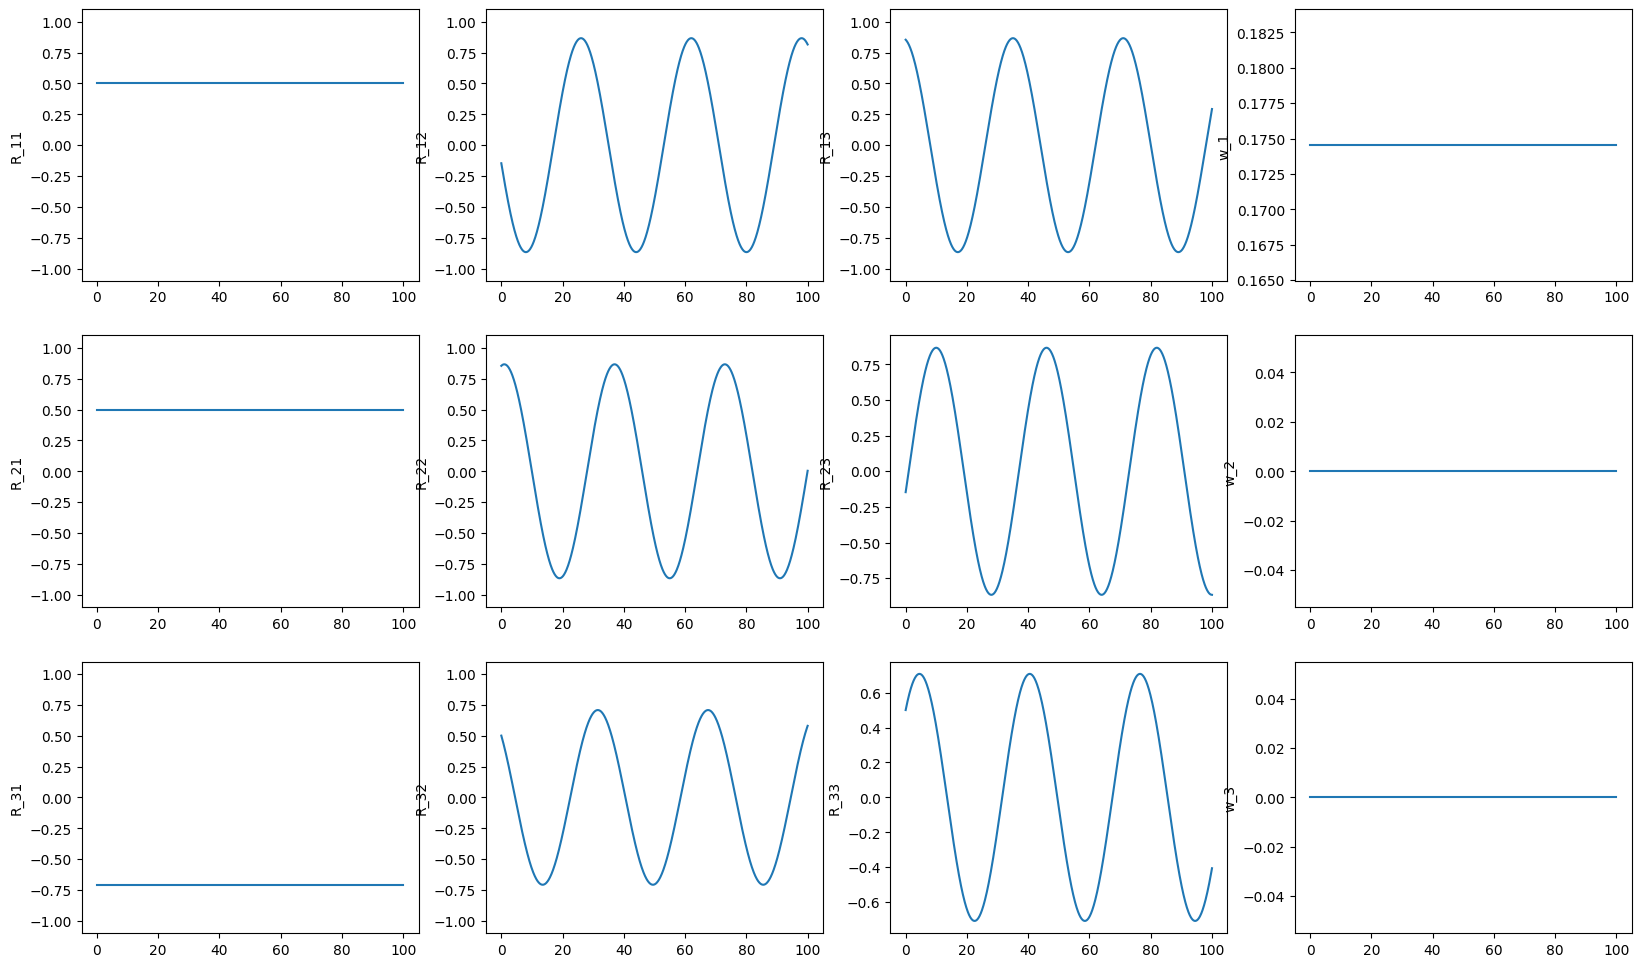

In [ ]:
# time points
t = np.linspace(0, 100, 1001)

# integrate
y = odeint(R_model, s_0, t, args=(I,tau))
R_t = y[:,0:9]
w_t = y[:,9::]

fig = plt.figure(figsize=(20,12))
plt.subplot(3,4,1)
plt.plot(t,R_t[:,0])
plt.ylabel('R_11')
plt.ylim(-1.1,1.1)
plt.subplot(342)
plt.plot(t,R_t[:,1])
plt.ylabel('R_12')
plt.ylim(-1.1,1.1)
plt.subplot(343)
plt.plot(t,R_t[:,2])
plt.ylabel('R_13')
plt.ylim(-1.1,1.1)
plt.subplot(344)
plt.plot(t,w_t[:,0])
plt.ylabel('w_1')
plt.subplot(345)
plt.plot(t,R_t[:,3])
plt.ylabel('R_21')
plt.ylim(-1.1,1.1)
plt.subplot(346)
plt.plot(t,R_t[:,4])
plt.ylabel('R_22')
plt.ylim(-1.1,1.1)
plt.subplot(347)
plt.plot(t,R_t[:,5])
plt.ylabel('R_23')
plt.subplot(348)
plt.plot(t,w_t[:,1])
plt.ylabel('w_2')
plt.subplot(349)
plt.plot(t,R_t[:,6])
plt.ylabel('R_31')
plt.ylim(-1.1,1.1)
plt.subplot(3,4,10)
plt.plot(t,R_t[:,7])
plt.ylabel('R_32')
plt.ylim(-1.1,1.1)
plt.subplot(3,4,11)
plt.plot(t,R_t[:,8])
plt.ylabel('R_33')
plt.subplot(3,4,12)
plt.plot(t,w_t[:,2])
plt.ylabel('w_3')


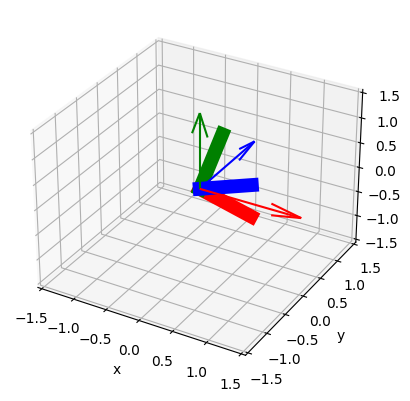

In [ ]:
# animate what this rotation looks like

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# object initialization
i = 0
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, normalize=True, color = 'red')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, normalize=True, color = 'blue')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, normalize=True, color = 'green')
ax.set(xlim=(-1.5,1.5), 
          ylim=(-1.5,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t[0,0]], [0,R_t[0,3]], [0,R_t[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t[0,1]], [0,R_t[0,4]], [0,R_t[0,7]], color = 'green', linewidth = 10)
z_b, = ax.plot([0,R_t[0,2]], [0,R_t[0,5]], [0,R_t[0,8]], color = 'blue', linewidth = 10)


In [ ]:
# animation function. This is called sequentially
def drawframe(n): 
    x_b.set_data([0,R_t[n,0]], [0,R_t[n,1]])
    x_b.set_3d_properties([0,R_t[n,2]], 'z')
    y_b.set_data([0,R_t[n,3]], [0,R_t[n,4]])
    y_b.set_3d_properties([0,R_t[n,5]], 'z')
    z_b.set_data([0,R_t[n,6]], [0,R_t[n,7]])
    z_b.set_3d_properties([0,R_t[n,8]], 'z')
    return (x_b, y_b, z_b)

anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

# now let's investigate motion using the quaternion kinematics

In [ ]:
# initiate state with quaternion
s_0 = np.concatenate((q_0,omega_0), axis=0)

# code the ordinary differential equation that defines the state derivative with respect to a quaternion state
## derived from Euler's rigid body dynamics equation

In [ ]:
# ode for kinematics/dynamics using quaternion state
def q_model(s,t,I,tau):
    # break out state
    q1 = s[0]
    q2 = s[1]
    q3 = s[2]
    q4 = s[3]
    w1 = s[4]
    w2 = s[5]
    w3 = s[6]
    w = np.array([[w1],[w2],[w3]])
    
    # define derivative
    qmat = np.array([[q4, -q3, q2],
                     [q3, q4, -q1],
                     [-q2, q1, q4],
                     [-q1, -q2, -q3]])
    qdot = 1/2*qmat@w
    
    wcross = np.array([[0,-w3,w2],
                       [w3,0,-w1],
                       [-w2,w1,0]])
    wdot = -np.linalg.inv(I)@(wcross@(I@w)-tau)

    # return state derivative
    sdot = np.concatenate((qdot[:,0],wdot[:,0]), axis=0)
    
    return sdot

## run the dynamics model with no external torque

In [ ]:
# time points
t = np.linspace(0, 100, 1001)

# integrate
y = odeint(q_model, s_0, t, args=(I,tau))

## plot the resulting attitude dynamics of the spacecraft

Text(0.5, 1.0, 'axis component w_3')

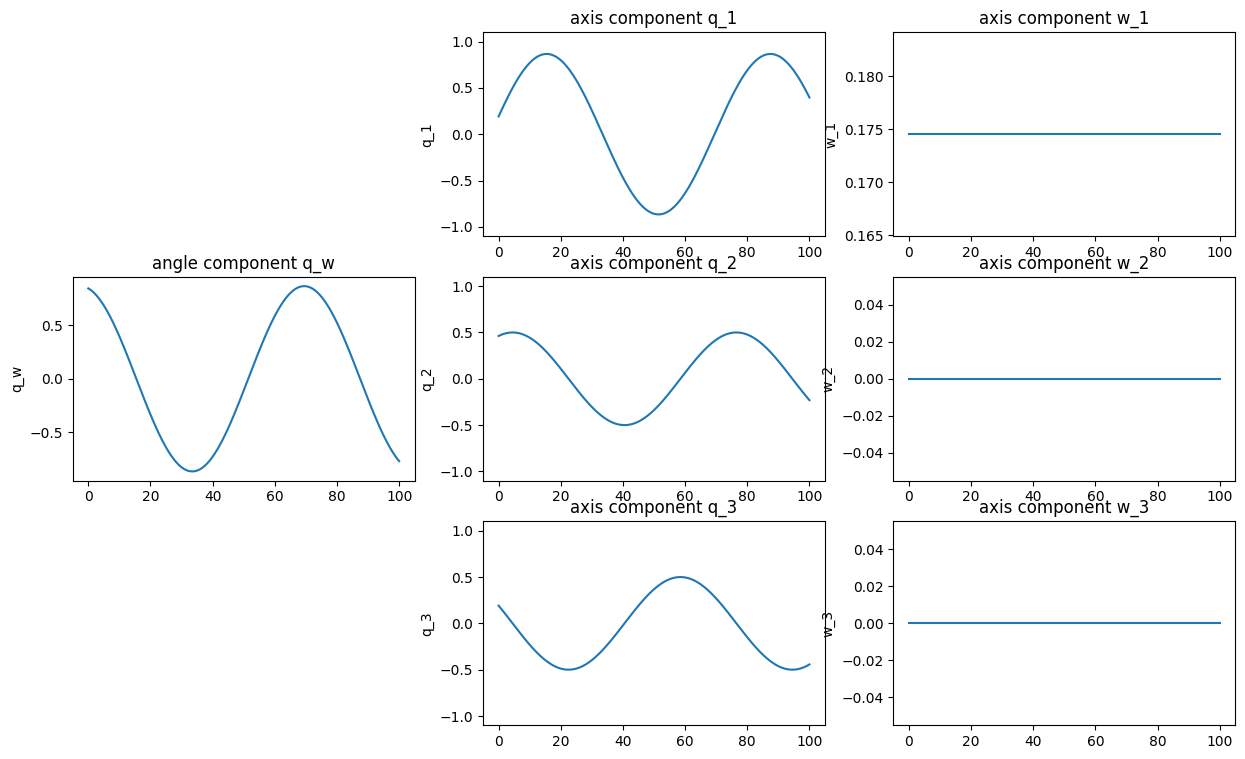

In [ ]:
q_t = y[:,0:4]
# for i in range(len(q_t)):
#     q = q_t[i,:]
#     qmag = np.sqrt(q.dot(q))
#     q_t[i,:] = q/qmag
#     print(qmag)
w_t = y[:,4:7]

fig = plt.figure(figsize=(15,9))
plt.subplot(332)
plt.plot(t,q_t[:,0])
plt.ylabel('q_1')
plt.title('axis component q_1')
plt.ylim(-1.1,1.1)
plt.subplot(335)
plt.plot(t,q_t[:,1])
plt.ylabel('q_2')
plt.title('axis component q_2')
plt.ylim(-1.1,1.1)
plt.subplot(338)
plt.plot(t,q_t[:,2])
plt.ylabel('q_3')
plt.title('axis component q_3')
plt.ylim(-1.1,1.1)
plt.subplot(334)
plt.plot(t,q_t[:,3])
plt.ylabel('q_w')
plt.title('angle component q_w')
plt.subplot(333)
plt.plot(t,w_t[:,0])
plt.ylabel('w_1')
plt.title('axis component w_1')
plt.subplot(336)
plt.plot(t,w_t[:,1])
plt.ylabel('w_2')
plt.title('axis component w_2')
plt.subplot(339)
plt.plot(t,w_t[:,2])
plt.ylabel('w_3')
plt.title('axis component w_3')


# off-diagonal inertia products

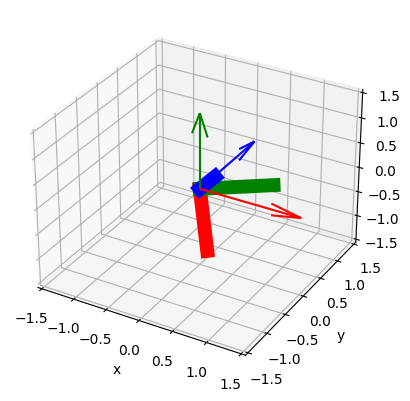

In [ ]:
# add off-diagonal inertia to inertia matrix FEEL FREE TO MODIFY
I = np.array([[I_xx, 0.5*I_xx, 0],[0.5*I_xx, I_yy, 0],[0, 0 ,I_zz]])

# time points
t = np.linspace(0, 100, 1001)

#external torque
tau = np.array([[0],[0],[0]])

# initiate state with rotation matrix
r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
s_0 = np.concatenate((r_0,omega_0), axis=0)

# integrate
y = odeint(R_model, s_0, t, args=(I,tau))
R_t = y[:,0:9]
w_t = y[:,9::]

# animate what this rotation looks like

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# object initialization
i = 0
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, normalize=True, color = 'red')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, normalize=True, color = 'blue')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, normalize=True, color = 'green')
ax.set(xlim=(-1.5,1.5), 
          ylim=(-1.5,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t[0,0]], [0,R_t[0,3]], [0,R_t[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t[0,1]], [0,R_t[0,4]], [0,R_t[0,7]], color = 'green', linewidth = 10)
z_b, = ax.plot([0,R_t[0,2]], [0,R_t[0,5]], [0,R_t[0,8]], color = 'blue', linewidth = 10)

anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

array([[ 0.5       , -0.14644661,  0.85355339, ..., -0.70710678,
         0.5       ,  0.5       ],
       [ 0.5       , -0.16132085,  0.85086755, ..., -0.70710678,
         0.49119765,  0.50865004],
       [ 0.5       , -0.17614596,  0.84792252, ..., -0.70710678,
         0.48224568,  0.51714515],
       ...,
       [ 0.5       ,  0.82486533,  0.26381304, ..., -0.70710678,
         0.56472061, -0.42554756],
       [ 0.5       ,  0.82013553,  0.27816875, ..., -0.70710678,
         0.57206143, -0.41562701],
       [ 0.5       ,  0.8151559 ,  0.29243972, ..., -0.70710678,
         0.57922799, -0.40557986]])

# result of external torques

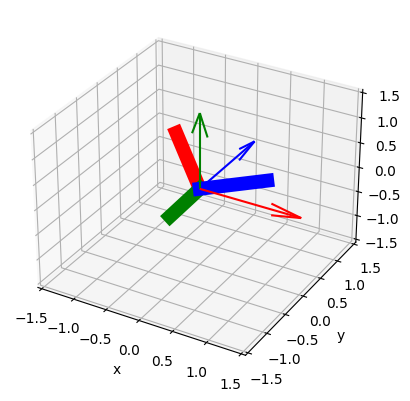

In [ ]:
# add off-diagonal inertia to inertia matrix 
I = np.array([[I_xx, 0, 0],[0, I_yy, 0],[0, 0 ,I_zz]])

# time points
t = np.linspace(0, 10, 101)

#external torque FEEL FREE TO MODIFY
tau = np.array([[0],[0],[.001]])

# initiate state with rotation matrix
r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
s_0 = np.concatenate((r_0,omega_0), axis=0)

# integrate
y = odeint(R_model, s_0, t, args=(I,tau))
R_t = y[:,0:9]
w_t = y[:,9::]

# animate what this rotation looks like

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# object initialization
i = 0
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, normalize=True, color = 'red')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, normalize=True, color = 'blue')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, normalize=True, color = 'green')
ax.set(xlim=(-1.5,1.5), 
          ylim=(-1.5,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t[0,0]], [0,R_t[0,3]], [0,R_t[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t[0,1]], [0,R_t[0,4]], [0,R_t[0,7]], color = 'green', linewidth = 10)
z_b, = ax.plot([0,R_t[0,2]], [0,R_t[0,5]], [0,R_t[0,8]], color = 'blue', linewidth = 10)

anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())